# Rede MLP

## Dataset Respiratory_Sound_Database_Pneumo_Healthy_Only - Dataset 2 - trim8

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import librosa
import librosa.display
import glob

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from livelossplot import PlotLossesKeras

/home/lucas/anaconda3/envs/ic/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/lucas/anaconda3/envs/ic/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
GROUP_TRAIN = 'trim8'
GROUP_TEST = 'trim8'
USE_TEST_AS_VALIDATION_DATA = False
DATASET = 'dataset_2'
DATASET_TRAIN = DATASET
DATASET_TEST = DATASET
DURATION = 8
SIZE = 345
CSV_TRAIN = 'train2.csv'
CSV_TEST = 'test2.csv'
"""
model1
model1dropout1
model1dropout2
model1kernelL1
model2
model3
model4
model4kernelL1
"""
TOPOLOGY = 'model4kernelL1'
MODEL_NAME = f'{TOPOLOGY}_{DATASET}_{GROUP_TRAIN}_val_is_test_{USE_TEST_AS_VALIDATION_DATA}'

In [4]:
train_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TRAIN}/train/**/*.wav', recursive=True)
train_file_names = [os.path.splitext(os.path.basename(p))[0] for p in train_file_paths]

test_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TEST}/test/**/*.wav', recursive=True)
test_file_names = [os.path.splitext(os.path.basename(p))[0] for p in test_file_paths]

In [5]:
train_p_id_in_file = [] # patient IDs corresponding to each file
test_p_id_in_file = [] # patient IDs corresponding to each file
for name in train_file_names:
    train_p_id_in_file.append(int(name[:3]))

for name in test_file_names:
    test_p_id_in_file.append(int(name[:3]))

train_p_id_in_file = np.array(train_p_id_in_file)
test_p_id_in_file = np.array(test_p_id_in_file) 

In [6]:
max_pad_len = SIZE
features_path = f'features/{DATASET}{os.sep}{DURATION}'

os.makedirs(features_path, exist_ok=True)

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
    feature_name = f'{os.path.splitext(os.path.basename(file_name))[0]}.npy'
    feature_path = os.path.join(features_path, feature_name)
    if (os.path.isfile(feature_path)):
        return np.load(feature_path)
    
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=DURATION) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    np.save(feature_path, mfccs)
    return mfccs

In [7]:
#filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [8]:
train_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TRAIN}", header=None) # patient diagnosis file
test_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TEST}", header=None) # patient diagnosis file

In [9]:
train_labels = np.array([train_p_diag[train_p_diag[0] == x][1].values[0] for x in train_p_id_in_file]) 
test_labels = np.array([test_p_diag[test_p_diag[0] == x][1].values[0] for x in test_p_id_in_file]) 

In [10]:
train_features = [] 
test_features = []

for file_name in train_file_paths:
    data = extract_features(file_name)
    train_features.append(data)

for file_name in test_file_paths:
    data = extract_features(file_name)
    test_features.append(data)

print('Finished feature extraction from ', (len(train_features)+len(train_features)), ' files')
train_features = np.array(train_features)
test_features = np.array(test_features)

Finished feature extraction from  224  files


In [11]:
np.unique(train_labels)

array(['Healthy', 'Pneumonia'], dtype='<U9')

In [12]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['Healthy' 'Pneumonia']
 ['64' '48']]
[['Healthy' 'Pneumonia']
 ['6' '26']]


__Balanceando dados__

In [13]:
def balance_data(X, labels):
    """Balances data duplicating some instances of the minority classes"""
    balX = None
    baly = None
    unique, counts = np.unique(labels, return_counts=True)
    max_inst = max(counts)
    # For every class duplicate the necessary amount
    for label in unique:
        data_of_label = []
        for x, y in zip(X, labels):
            if y == label:
                data_of_label.append(x)
        data_of_label = np.asarray(data_of_label)
        extra = data_of_label[np.random.choice(data_of_label.shape[0],
                                               max_inst,
                                               replace=True), :]
        if balX is not None:
            balX = np.stack((balX, extra), axis = 0) 
            baly = np.stack((baly, np.asarray([label for i in range(len(extra))])))
        else:
            balX = extra
            baly = np.asarray([label for i in range(len(extra))])
    balX = np.concatenate(balX)
    baly = np.concatenate(baly)
    return balX, baly

In [14]:
train_features, train_labels = balance_data(train_features, train_labels)
test_features, test_labels = balance_data(test_features, test_labels)

In [15]:
# One-hot encode labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_cat = to_categorical(le.transform(train_labels)) 
test_labels_cat = to_categorical(le.transform(test_labels)) 

In [16]:
train_features.shape

(128, 40, 345)

In [17]:
input_dim = train_features.shape[1]*train_features.shape[2]

In [18]:
train_features = np.reshape(train_features, (train_features.shape[0], input_dim))
print(train_features.shape, train_labels_cat.shape)
test_features = np.reshape(test_features, (test_features.shape[0], input_dim))
print(test_features.shape, test_labels_cat.shape)

(128, 13800) (128, 2)
(52, 13800) (52, 2)


In [19]:
x_test, y_test = test_features, test_labels_cat
x_train, y_train = train_features, train_labels_cat

In [20]:
if USE_TEST_AS_VALIDATION_DATA:
    x_val, y_val = x_test, y_test
else:
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                      test_size=0.1, random_state = 42)

**MLP model architecture**

In [21]:
def model1():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [22]:
def model1dropout1():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [23]:
def model1dropout2():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [24]:
def model1kernelL1():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [25]:
def model2():
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [26]:
def model3():
    model = Sequential()
    model.add(Dense(40, activation='relu', input_dim=input_dim))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [27]:
def model4():
    model = Sequential()
    model.add(Dense(30, activation='relu', input_dim=input_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [28]:
def model4kernelL1():
    model = Sequential()
    model.add(Dense(30, activation='relu', input_dim=input_dim))
    model.add(Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [29]:
num_labels = train_labels_cat.shape[1]
model = globals()[TOPOLOGY]()

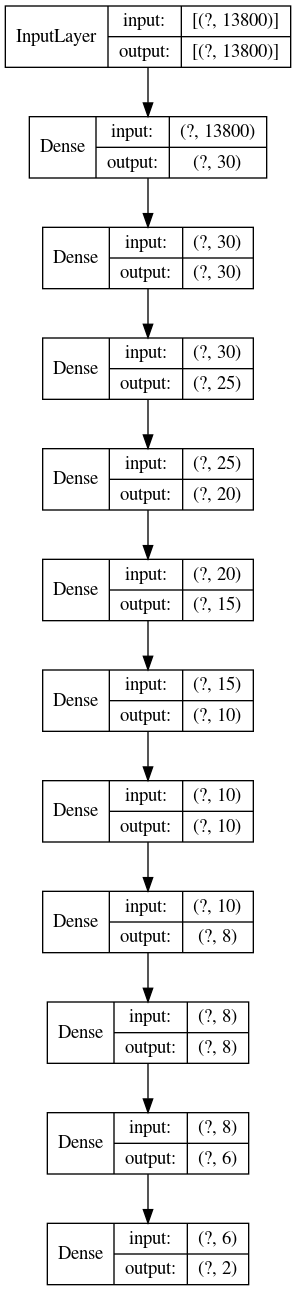

In [30]:
os.makedirs('topologias', exist_ok=True)
plot_model(model, to_file=f'topologias{os.sep}{MODEL_NAME}.png',
           show_shapes=True, show_layer_names=False)

In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [32]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                414030    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

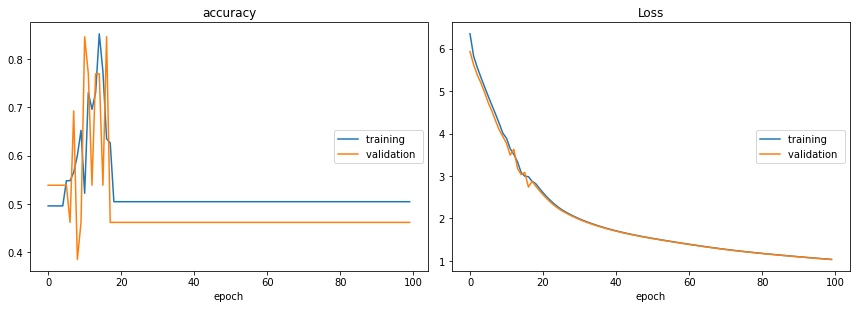

accuracy
	training         	 (min:    0.496, max:    0.852, cur:    0.504)
	validation       	 (min:    0.385, max:    0.846, cur:    0.462)
Loss
	training         	 (min:    1.037, max:    6.347, cur:    1.037)
	validation       	 (min:    1.035, max:    5.929, cur:    1.035)
Training completed in time:  0:00:34.176958


In [33]:
# train model
num_epochs = 100
num_batch_size = 10
checkpoint_filepath = f'models/{MODEL_NAME}.h5'

os.makedirs('models', exist_ok=True)
callbacks = [
    PlotLossesKeras(),
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=0)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val), callbacks=callbacks, verbose=0)


duration = datetime.now() - start
print("Training completed in time: ", duration)

## Teste (melhor modelo)

In [34]:
model = load_model(checkpoint_filepath)
score = model.evaluate(x_train, y_train, verbose=0)
train_loss, train_acc = score[0], score[1]
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
test_loss, test_acc = score[0], score[1]
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.70434785
Testing Accuracy:  0.65384614


**Plot accuracies and losses**

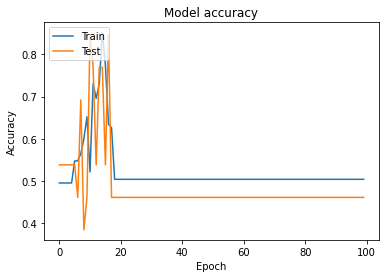

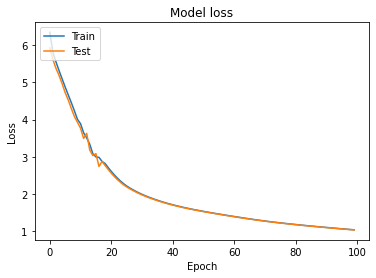

In [35]:
os.makedirs('graficos', exist_ok=True)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'graficos{os.sep}{MODEL_NAME}_accuracy_{train_acc}_{test_acc}.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'graficos{os.sep}{MODEL_NAME}_loss_{train_loss}_{test_loss}.png')
plt.show()

In [36]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [38]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names = ['Healthy', 'Pneumonia']

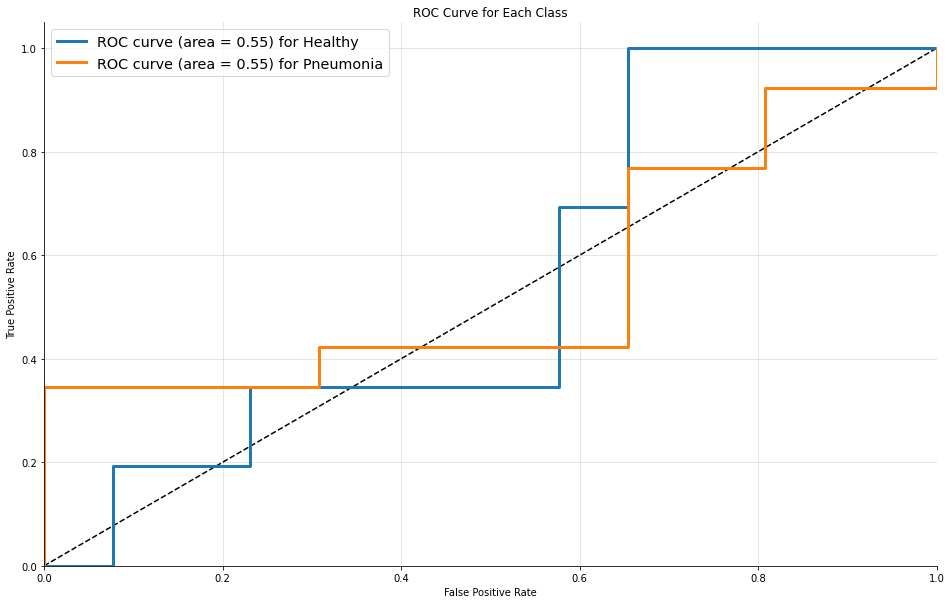

In [39]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [40]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

     Healthy       0.59      1.00      0.74        26
   Pneumonia       1.00      0.31      0.47        26

    accuracy                           0.65        52
   macro avg       0.80      0.65      0.61        52
weighted avg       0.80      0.65      0.61        52



In [41]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[26  0]
 [18  8]]


In [42]:
import itertools
def plot_confusion_matrix(cm, unique_labels, show=True, output=None,
                          title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() + 1).astype(str))
    plt.yticks(tick_marks)

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if output is not None:
        plt.savefig(output)
    if show:
        plt.show()
    plt.close()
    return output


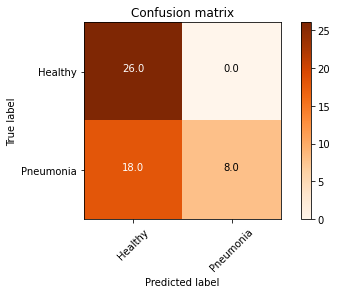

'cm/model4kernelL1_dataset_2_trim8_val_is_test_False_0.7043478488922119_0.6538461446762085.png'

In [43]:
os.makedirs('cm', exist_ok=True)
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds), unique_labels=["Healthy", "Pneumonia"],
                      output=os.path.join('cm', f'{MODEL_NAME}_{train_acc}_{test_acc}.png'))

__Write csv__

In [44]:
with open('report.csv', 'a') as report:
    report.write(f'{MODEL_NAME},{DATASET},{GROUP_TRAIN},{DURATION},{USE_TEST_AS_VALIDATION_DATA},{train_acc},{test_acc}\n')